Visualizing the predictions made on test of DAVIS (part of the training_validation process)

Mean Squared Error (MSE): 0.263
Mean Absolute Error (MAE): 0.287
R² Score: 0.672
Spearman Correlation: 0.681
Pearson Correlation: 0.820


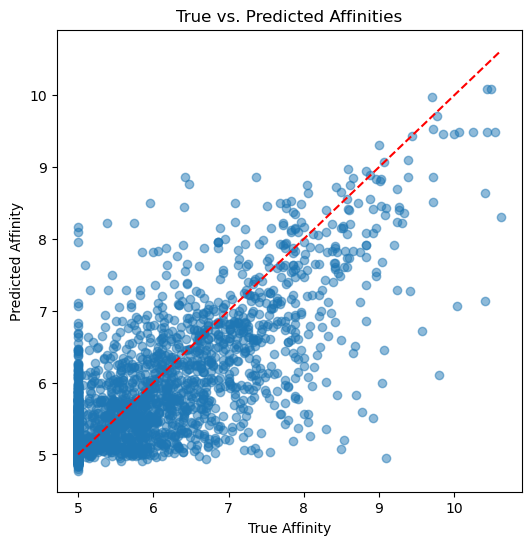

In [2]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats
import matplotlib.pyplot as plt

# Load predictions
df = pd.read_csv("../results/1_21/predictions_GINConvNet_davis.csv")

# Extract True Labels and Predicted Scores
y_true = df["True_Label"].values
y_pred = df["Predicted_Value"].values

# Compute regression metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
spearman_corr, _ = stats.spearmanr(y_true, y_pred)
pearson_corr, _ = stats.pearsonr(y_true, y_pred)

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R² Score: {r2:.3f}")
print(f"Spearman Correlation: {spearman_corr:.3f}")
print(f"Pearson Correlation: {pearson_corr:.3f}")

# Scatter plot of true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle="--")  # Identity line
plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("True vs. Predicted Affinities")
plt.show()


training_validtation on DAVIS here will pass in pharos to outputed model

In [3]:
import sys
# Add the project directory to the Python path
sys.path.append('/Users/adele/Documents/GitHub/GraphDTA')

In [7]:
import torch
import numpy as np
from torch_geometric.data import DataLoader
from models.ginconv import GINConvNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the validation dataset
validation_data = torch.load('data/processed/pharos.pt')

# Create a DataLoader for the validation dataset
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=False)

for batch in validation_loader:
    print(batch)  # This will print the batch structure, useful for debugging
    break  # Print only the first batch to inspect structure

for batch in validation_loader:
    affinities = batch.y  # Extract the affinity values
    print(affinities)  # Print affinities for this batch


DataBatch(x=[914, 78], edge_index=[2, 1984], y=[32], target=[32, 1000], c_size=[32], batch=[914], ptr=[33])
tensor([7.6200, 8.3100, 8.3100, 8.3100, 8.3100, 6.3700, 6.7100, 7.1100, 7.1000,
        6.5300, 7.0600, 7.9600, 6.5600, 6.0900, 7.2800, 6.2800, 6.1700, 6.3000,
        6.8400, 6.3800, 6.6000, 4.5200, 8.0000, 8.0000, 7.9000, 8.7000, 7.7500,
        7.1800, 6.5000, 6.2300, 6.0900, 8.7000])
tensor([ 7.5800,  8.6700, 10.4100,  9.5900,  6.8000,  7.6400,  7.6200,  9.1500,
         8.7000,  8.5200,  8.1500,  8.1500,  8.0000,  7.9600,  7.8900,  7.6800,
         7.6600,  7.6200,  7.2800,  7.1100,  7.1100,  7.1000,  7.0600,  6.9800,
         6.9700,  6.9200,  6.8100,  6.7100,  6.6900,  6.5600,  6.5400,  6.5300])
tensor([6.3700, 6.3300, 6.3000, 6.0900, 6.0800, 6.0600, 6.0300, 6.0200, 6.0000,
        6.2800, 8.3100, 8.3100, 7.1000, 6.6500, 6.6400, 6.1000, 8.3100, 8.3100,
        8.3100, 8.3100, 7.7400, 6.7700, 6.8800, 6.7700, 8.3100, 8.3100, 8.5200,
        8.5200, 8.3000, 8.3000, 8.3000, 8.

/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_6241/1346817232.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  validation_data = torch.load('data/processed/p

In [5]:
import torch
import numpy as np

model = GINConvNet().to(device) 

model_file_name = '../results/1_21/model_GINConvNet_davis.model'
model.load_state_dict(torch.load(model_file_name, map_location=device))

# Define a function to make predictions
def predict_affinities(model, dataloader):
    model.eval()  
    all_preds = []
    all_true = []

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_data in dataloader:
            batch_data = batch_data.to(device)  # Move data to the appropriate device
            output = model(batch_data)  # Forward pass to get predictions

            # Store predicted and true values
            all_preds.append(output.cpu().numpy())  
            all_true.append(batch_data.y.cpu().numpy())  

    # Convert lists to numpy arrays
    predictions = np.concatenate(all_preds)
    true_values = np.concatenate(all_true)

    return true_values, predictions

# Run predictions on the validation data
y_true, y_pred = predict_affinities(model, validation_loader)

# Print results (formatted for readability)
print("True Values vs. Predicted Affinities:")
for true_val, pred_val in zip(y_true.flatten(), y_pred.flatten()):  # Ensure values are scalars
    print(f"True: {true_val:.3f}, Predicted: {pred_val:.3f}")


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_44838/3517175020.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file_n

True Values vs. Predicted Affinities:
True: 7.620, Predicted: 5.983
True: 8.310, Predicted: 5.138
True: 8.310, Predicted: 5.136
True: 8.310, Predicted: 5.089
True: 8.310, Predicted: 5.116
True: 6.370, Predicted: 5.806
True: 6.710, Predicted: 5.015
True: 7.110, Predicted: 5.086
True: 7.100, Predicted: 5.259
True: 6.530, Predicted: 5.673
True: 7.060, Predicted: 5.291
True: 7.960, Predicted: 5.258
True: 6.560, Predicted: 5.407
True: 6.090, Predicted: 4.813
True: 7.280, Predicted: 4.795
True: 6.280, Predicted: 5.030
True: 6.170, Predicted: 5.420
True: 6.300, Predicted: 5.281
True: 6.840, Predicted: 5.008
True: 6.380, Predicted: 5.181
True: 6.600, Predicted: 5.241
True: 4.520, Predicted: 5.019
True: 8.000, Predicted: 5.080
True: 8.000, Predicted: 5.080
True: 7.900, Predicted: 4.955
True: 8.700, Predicted: 5.005
True: 7.750, Predicted: 5.047
True: 7.180, Predicted: 4.354
True: 6.500, Predicted: 4.565
True: 6.230, Predicted: 4.590
True: 6.090, Predicted: 4.621
True: 8.700, Predicted: 4.952
Tr

Mean Squared Error (MSE): 5.888
Mean Absolute Error (MAE): 2.290
R² Score: -14.293
Spearman Correlation: 0.049
Pearson Correlation: 0.091


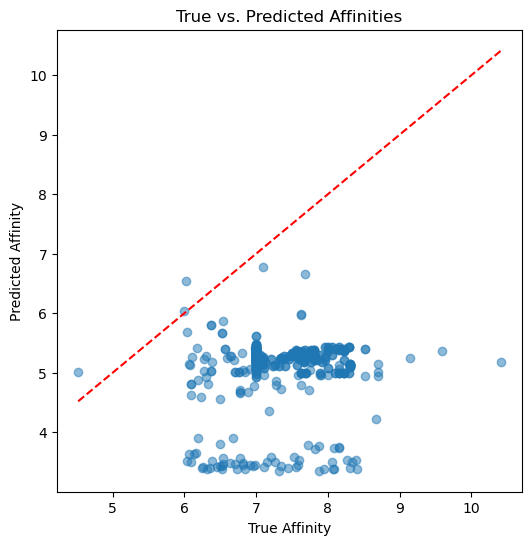

In [6]:
# Compute regression metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
pearson_corr, _ = stats.pearsonr(y_true.flatten(), y_pred.flatten())  # Extract first value
spearman_corr, _ = stats.spearmanr(y_true.flatten(), y_pred.flatten())  # Extract first value


# Print metrics
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R² Score: {r2:.3f}")
print(f"Spearman Correlation: {spearman_corr:.3f}")
print(f"Pearson Correlation: {pearson_corr:.3f}")

# Scatter plot of true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle="--")  # Identity line
plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("True vs. Predicted Affinities")
plt.show()

### Stats about the train test split of DAVIS used in GraphDTA

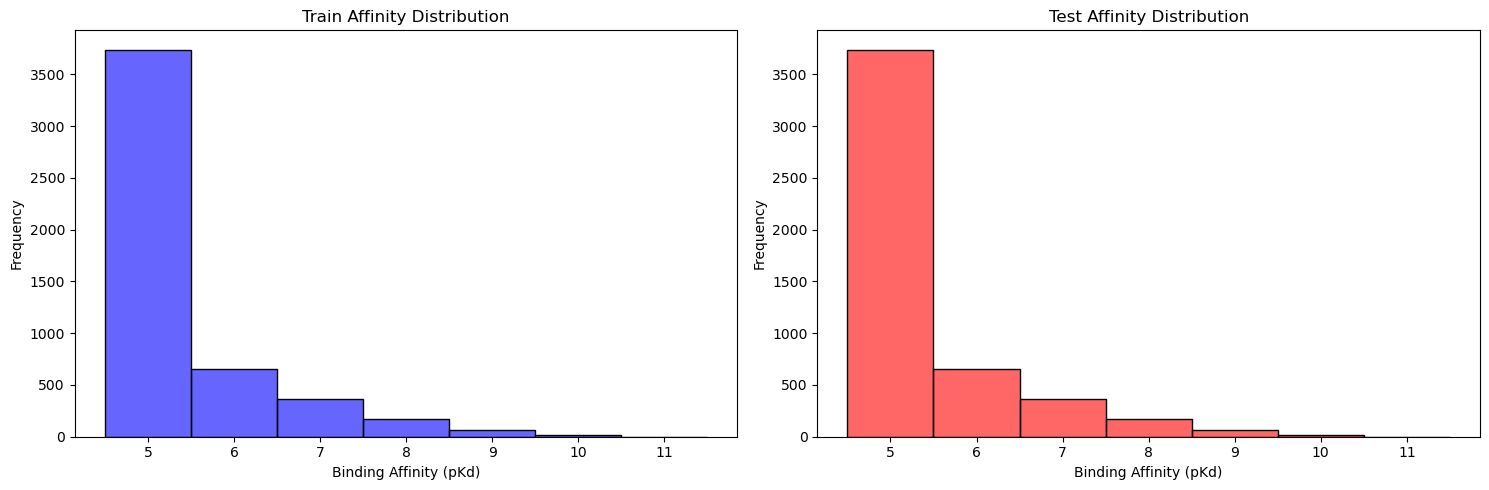

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
test_df = pd.read_csv('/Users/adele/Documents/GitHub/GraphDTA/data/davis_test.csv')
train_df = pd.read_csv('/Users/adele/Documents/GitHub/GraphDTA/data/davis_test.csv')

# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train Affinity Histogram
sns.histplot(train_df["affinity"], kde=False, color="blue", bins=20, alpha=0.6, discrete=True, ax=axes[0])
axes[0].set_title("Train Affinity Distribution")
axes[0].set_xlabel("Binding Affinity (pKd)")
axes[0].set_ylabel("Frequency")

# Test Affinity Histogram
sns.histplot(test_df["affinity"], kde=False, color="red", bins=20, alpha=0.6, discrete=True, ax=axes[1])
axes[1].set_title("Test Affinity Distribution")
axes[1].set_xlabel("Binding Affinity (pKd)")
axes[1].set_ylabel("Frequency")

# Adjust layout and show plot
plt.tight_layout()
plt.show()


# Ensure no overlap in proteins
# assert len(set(train_df["target_sequence"]) & set(test_df["target_sequence"])) == 0, "Leakage detected!"
# print("No protein overlap between training and test sets!")


### Run on full pharos minus reclassified

In [ ]:
import torch
import numpy as np
from torch_geometric.data import DataLoader
from models.ginconv import GINConvNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the validation dataset
validation_data = torch.load('data/processed/pharos_original.pt') 
print(type(validation_data))
print(len(validation_data))


# Create a DataLoader for the validation dataset
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=False)

for batch in validation_loader:
    print(batch)  # This will print the batch structure, useful for debugging
    break  # Print only the first batch to inspect structure

for batch in validation_loader:
    affinities = batch.y  # Extract the affinity values
    print(affinities)  # Print affinities for this batch


<class 'dict'>
5


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_44838/1849686249.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  validation_data = torch.load('data/processed/

KeyError: 0

In [ ]:
import torch
import numpy as np


model = GINConvNet().to(device) 

model_file_name = '../results/1_21/model_GINConvNet_davis.model'
model.load_state_dict(torch.load(model_file_name, map_location=device))

# Define a function to make predictions
def predict_affinities(model, dataloader):
    model.eval()  
    all_preds = []
    all_true = []

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_data in dataloader:
            batch_data = batch_data.to(device)  # Move data to the appropriate device
            output = model(batch_data)  # Forward pass to get predictions

            # Store predicted and true values
            all_preds.append(output.cpu().numpy())  
            all_true.append(batch_data.y.cpu().numpy())  

    # Convert lists to numpy arrays
    predictions = np.concatenate(all_preds)
    true_values = np.concatenate(all_true)

    return true_values, predictions

# Run predictions on the validation data
y_true, y_pred = predict_affinities(model, validation_loader)

# Print results (formatted for readability)
print("True Values vs. Predicted Affinities:")
for true_val, pred_val in zip(y_true.flatten(), y_pred.flatten()):  # Ensure values are scalars
    print(f"True: {true_val:.3f}, Predicted: {pred_val:.3f}")


In [ ]:
# Compute regression metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
pearson_corr, _ = stats.pearsonr(y_true.flatten(), y_pred.flatten())  # Extract first value
spearman_corr, _ = stats.spearmanr(y_true.flatten(), y_pred.flatten())  # Extract first value


# Print metrics
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R² Score: {r2:.3f}")
print(f"Spearman Correlation: {spearman_corr:.3f}")
print(f"Pearson Correlation: {pearson_corr:.3f}")

# Scatter plot of true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle="--")  # Identity line
plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("True vs. Predicted Affinities")
plt.show()

### Blind 20% of proteins can maybe do same as MolTrans but also probably fine to do a different set